In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import itertools
import random
import librosa
from keras import backend as K

In [12]:
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

X_train_scaled = (X_train - 0.5) * 2.0

Y_train_onehot = tf.keras.utils.to_categorical(Y_train, num_classes=10)
Y_test_onehot = tf.keras.utils.to_categorical(Y_test, num_classes=10)

In [22]:
def discriminant_images(dis_cond, mnist_labels, mnist_data):
    
    selected_images = []
    
    for label in dis_cond:
        indices = np.where(mnist_labels == label)[0]
        selected_index = np.random.choice(indices)
        selected_images.append(mnist_data[selected_index])
    
    selected_images = np.array(selected_images)
    selected_images = selected_images.reshape(selected_images.shape[0], -1)
    
    return selected_images

In [23]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(200, input_shape = (110, ), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(400, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(784, activation='tanh'))
    
    gen_in = tf.keras.layers.Input(shape= (100,))
    gen_cond = tf.keras.layers.Input(shape= (10,))
    concat = tf.keras.layers.Concatenate(axis = -1)([gen_in, gen_cond])
    img = model(concat)
    
    return  tf.keras.models.Model([gen_in, gen_cond], img)

generator = build_generator()
# generator.summary()

In [24]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(400, input_shape = (794,), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(200, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    
    disc_in = tf.keras.layers.Input(shape= (784,))
    disc_cond = tf.keras.layers.Input(shape= (10,))
    concat = tf.keras.layers.Concatenate(axis = -1)([disc_in, disc_cond])
    prediction = model(concat)
    
    return tf.keras.models.Model([disc_in, disc_cond], prediction)

discriminator = build_discriminator()
# discriminator.summary()

In [25]:
discriminator.compile(loss = 'binary_crossentropy', optimizer =  tf.keras.optimizers.legacy.Adam(0.0002, 0.5), metrics = ['accuracy'])

gen_in = tf.keras.layers.Input(shape=(100,))
gen_cond = tf.keras.layers.Input(shape=(10,))
gen_out = generator([gen_in, gen_cond])

discriminator.trainable = False
prediction = discriminator([gen_out, gen_cond])

cgan = tf.keras.models.Model([gen_in, gen_cond], prediction)
cgan.compile(loss= 'binary_crossentropy', optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5))

In [ ]:
learning_rate = 0.00001
batch_size = 100
num_epochs = 300

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

labels = np.eye(10)
num_repeats = 10
gen_cond = np.vstack([np.tile(labels[i], (num_repeats, 1)) for i in range(10)])
dis_cond = np.repeat(np.arange(10), num_repeats)

real_accu=[]
fake_accu=[]

for epoch in range(num_epochs):
    
    for i in range(0, len(X_train), batch_size):
        
        real_images = discriminant_images(dis_cond, Y_train, X_train_scaled)
        
        gen_in = np.random.normal(0, 1, size=(batch_size, 100))
        gen_out = generator.predict([gen_in, gen_cond], verbose=0)
        
        d_loss_real = discriminator.train_on_batch([real_images, gen_cond], real)
        d_loss_fake = discriminator.train_on_batch([gen_out, gen_cond], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        gen_in = np.random.normal(0, 1, size=(batch_size, 100))
        
        g_loss = cgan.train_on_batch([gen_in, gen_cond], real)
        
    real_accu.append(d_loss_real[1])
    fake_accu.append(d_loss_fake[1])
    
    print('{} [Real loss: {:.4f}, Real accuracy: {:.2f}] [Fake loss: {:.4f}, Fake accuracy: {:.2f}] [G loss: {:.4f}]'
          .format(epoch, d_loss_real[0], d_loss_real[1], d_loss_fake[0], d_loss_fake[1], g_loss))


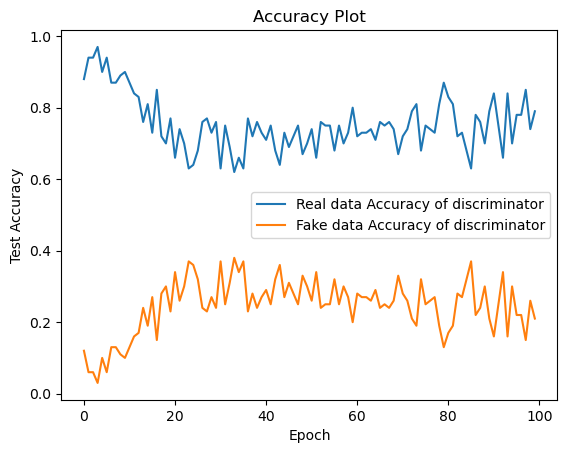

In [28]:
plt.figure()
fake_accu1 = [1 - accu_val for accu_val in real_accu]
plt.plot(real_accu, label='Real data Accuracy of discriminator')
plt.plot(fake_accu1, label='Fake data Accuracy of discriminator')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

In [14]:
gen_cond = np.vstack([np.tile(labels[i], (num_repeats, 1)) for i in range(10)])
gen_in = np.random.normal(0, 1, size=(100, 100))
gen_out = generator.predict([gen_in, gen_cond], verbose=0)

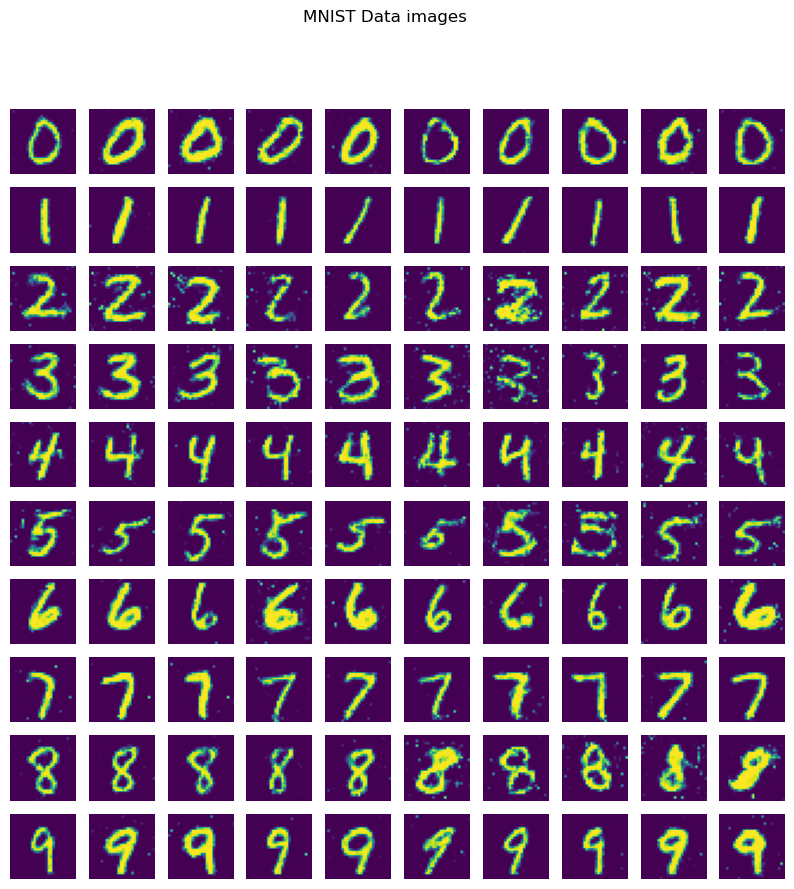

In [29]:
plt.figure(figsize=(10, 10))
plt.suptitle('MNIST Data images')
for i in range(10):
    for j in range(10):
        ax=plt.subplot2grid((10, 10), (i, j))
        image = gen_out[i*10+j]
        image_2d = tf.reshape(image, (28, 28))
        ax.imshow(image_2d)
        plt.axis('off')
